Executing 1st simulation...
avg_inference_time [0.034069 0.032146] ms
max_inference_time [0.06040002 0.0532    ] ms
Offline (post-simulation) rendering (using history)...


NameError: name '__file__' is not defined

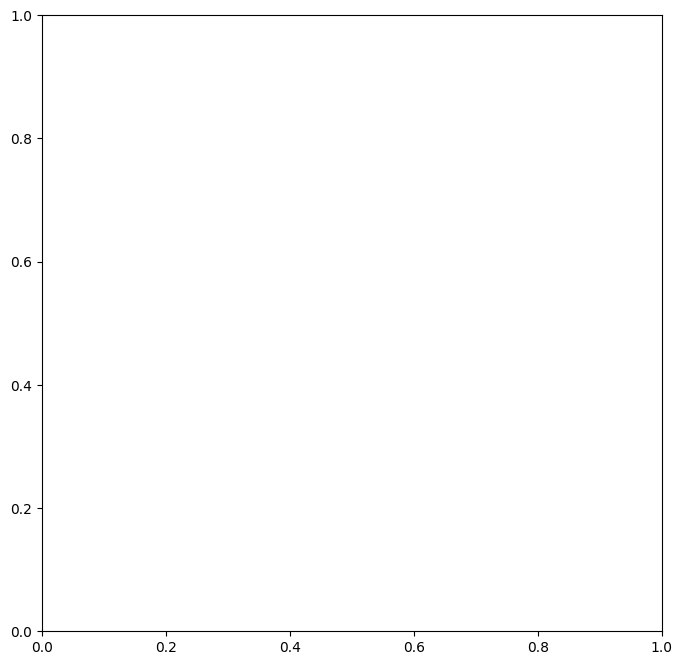

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jan 18 16:29:16 2024

@author: fperotto
"""

###############################################################################

import os

import numpy as np

from matplotlib import pyplot as plt
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
from matplotlib.collections import LineCollection
from matplotlib.path import Path
from matplotlib.lines import Line2D
from matplotlib import animation
from matplotlib.animation import FuncAnimation

from scipy import ndimage

###############################################################################

from acas.acasxu_basics import ACT_NAMES

###############################################################################

# 0: rho, distance (ft) [0, 60760]
# 1: theta, angle to intruder relative to ownship heading (rad) [-pi,+pi]
# 2: psi, heading of intruder relative to ownship heading (rad) [-pi,+pi]
# 3: v_own, speed of ownship (ft/sec) [100, 1145? 1200?] 
# 4: v_int, speed in intruder (ft/sec) [0? 60?, 1145? 1200?] 


###############################################################################


class AcasRender():

    def __init__(self, env,
                 airplane_size=200,   #30,   #ft
                 nmac_radius=500,    #153,   #ft
                 traj_linewidth = 1,
                 show_nmac_circle=True):

       self.env = env
       #verify that envs is a list
       #if not isinstance(self.envs, list): 
       #    self.envs = [self.envs]
       
       self.traj_linewidth = traj_linewidth

       self.airplane_size = airplane_size
       
       self.show_nmac_circle = show_nmac_circle
       self.nmac_radius = nmac_radius
           
       airplane_img_filepath = os.path.dirname(os.path.realpath(__file__)) + '/img/airplane.png'
       self.img = plt.imread(airplane_img_filepath)

       self.anim = None


    def plot(self, fig=None, ax=None, interval=20, show=True, save_as=None, title="ACAS-Xu Simulation"):
 
        #fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
        if ax is None:
            if fig is None:
                fig, ax = plt.subplots()
                #if len(self.envs) == 1:
                #    axes = [axes]
                fig.tight_layout()
            else:
                ax = fig.gca()
        
        #for env, ax in zip(self.envs, axes):
            
        ax.set_aspect('equal')
        #ax.axis('equal')
    
        ax.set_title(title)
        ax.set_xlabel('X Position (ft)')
        ax.set_ylabel('Y Position (ft)')
    
        palette = np.array(['gray', 'green', 'blue', 'magenta', 'red'])
        custom_lines = [Line2D([0], [0], color=c, lw=1) for c in palette]
        ax.legend(custom_lines, ACT_NAMES, fontsize=12)#, loc='lower left')

        num_airplanes = len(self.env.airplanes)
        total_time = len(self.env.states_history)
        H = np.array(self.env.states_history)
        A = np.array(self.env.commands_history)
        C = palette[A]

        #trajectories        
        lines = []
        lcs = []
        
        nmac_circles = []

        #text boxes        
        time_text = ax.text(0.02, 0.98, 'Time: 0 s', horizontalalignment='left', fontsize=12, verticalalignment='top', transform=ax.transAxes)
        time_text.set_visible(True)
        
        #airplanes
        airplane_img_boxes = []

        #lc = LineCollection([], lw=2, animated=True, color='k', zorder=1)
        #ax.add_collection(lc)
        
        for i in range(num_airplanes):
            
            #initial state
            x, y, theta, speed = H[0,i]
            x_f, y_f, theta_f, speed_f = H[-1,i]
            
            #total displacement
            d = speed * total_time
            dx = d * np.cos(theta)
            dy = d * np.sin(theta)
            
            # draw linear initial trajectory
            ax.scatter([x, x_f], [y, y_f], zorder=3, alpha=0.3)
            ax.plot([x, x+dx], [y, y+dy], ls=':', lw=1, color='lightgray', zorder=2)
            l = ax.plot(x, y, ls='-', lw=1, zorder=1)[0]
            #l = Line2D(x, y, lc='c', lw=1, ls='-', zorder=1)
            lines.append(l)
            lc = LineCollection([], linestyle='solid', lw=self.traj_linewidth, animated=True, color='k', zorder=1)
            ax.add_collection(lc)
            lcs.append(lc)
            
            #draw airplanes
            box = Bbox.from_bounds(x - self.airplane_size/2, y - self.airplane_size/2, self.airplane_size, self.airplane_size)
            tbox = TransformedBbox(box, ax.transData)
            box_image = BboxImage(tbox, zorder=2)
            airplane_img_boxes.append(box_image)
            theta_deg = (theta - np.pi / 2) / np.pi * 180 # original image is facing up, not right
            img_rotated = ndimage.rotate(self.img, theta_deg, order=1)
            box_image.set_data(img_rotated)
            ax.add_artist(box_image)
            if self.show_nmac_circle:
                nmac_circle = plt.Circle((x, y), self.nmac_radius, color='r', fill=False)
                nmac_circles.append(nmac_circle)
                ax.add_artist(nmac_circle)
                ax.add_patch(nmac_circle)
            
        artists = airplane_img_boxes + nmac_circles + lines + lcs + [time_text]

        def _init():
            time_text.set_text('Time: 0 s')
            for i, lc in enumerate(lcs):
                lc.get_paths().clear()
            return artists
        
        def _animate(n):
            time_text.set_text(f'Time: {n} s')
            #for i, l in enumerate(lines):
            for i, lc in enumerate(lcs):
                #airplane image
                box_image=airplane_img_boxes[i]
                #trajectory using lines
                #l.set_xdata(H[:n+1,i,0])
                #l.set_ydata(H[:n+1,i,1])
                #trajectory using paths
                paths = lc.get_paths()
                paths.append(Path([H[n,i,:2], H[n+1,i,:2]]))
                lc.set_colors(C[:n+1,i])
                x = H[n+1,i,0]
                y = H[n+1,i,1]
                theta = H[n+1,i,2]
                #airplane figure
                theta_deg = (theta - np.pi / 2) / np.pi * 180 # original image is facing up, not right
                original_size = list(self.img.shape)
                img_rotated = ndimage.rotate(self.img, theta_deg, order=1)
                rotated_size = list(img_rotated.shape)
                ratios = [r / o for r, o in zip(rotated_size, original_size)]
                box_image.set_data(img_rotated)
                width = self.airplane_size * ratios[0]
                height = self.airplane_size * ratios[1]
                box = Bbox.from_bounds(x - width/2, y - height/2, width, height)
                tbox = TransformedBbox(box, ax.transData)
                box_image.bbox = tbox
                if self.show_nmac_circle:
                    nmac_circle = nmac_circles[i]
                    nmac_circle.center = (x, y)
            return artists
        
        self.anim = FuncAnimation(fig, _animate, init_func=_init, frames=total_time-1, interval=interval, blit=True, repeat=True, repeat_delay=100)
        self.anim._is_paused = False
        
        #def on_click(event):
        #   if self.anim is not None:
        #      if self.anim._is_paused:
        #          self.anim.resume()
        #      else:
        #          self.anim.pause()
        #      self.anim._is_paused = not self.anim._is_paused
        #   #plt.close(fig)
        #fig.canvas.mpl_connect('button_press_event', on_click)
        
#        def on_close(event):
#            plt.close()
#            if anim is not None:
#                #self.my_anim.pause()
#                anim = None    #setting to None allows garbage collection and closes loop
#                del(anim)
#        fig.canvas.mpl_connect('close_event', on_close)

        def on_keypress(event):
            #DEFAULTS:
            #Home/Reset 	h or r or home
            #Back 	        c or left arrow or backspace
            #Forward 	    v or right arrow
            #Pan/Zoom 	    p
            #Zoom-to-rect 	o
            #Save 	        s or ctrl + s
            #Toggle fullscreen 	f or ctrl + f
            #Close plot 	ctrl + w
            #Close all plots 	shift + w
            #Constrain pan/zoom to x axis 	hold x when panning/zooming with mouse
            #Constrain pan/zoom to y axis 	hold y when panning/zooming with mouse
            #Preserve aspect ratio 	hold CONTROL when panning/zooming with mouse
            #Toggle major grids 	g when mouse is over an axes
            #Toggle minor grids 	G when mouse is over an axes
            #Toggle x axis scale (log/linear) 	L or k when mouse is over an axes
            #Toggle y axis scale (log/linear) 	l when mouse is over an axes            
            
            if event.key == 'z':
                if self.anim._is_paused:
                    self.anim.resume()
                else:
                    self.anim.pause()
                self.anim._is_paused = not self.anim._is_paused
            elif event.key == ' ':
                if self.anim._is_paused:
                    self.anim._step()

        fig.canvas.mpl_connect('key_press_event', on_keypress)
        
        if isinstance(save_as, str):
            if save_as[-4:] in [".mp4", ".mpg", ".mpeg"]:
                writer = animation.writers['ffmpeg'](fps=1000//interval, bitrate=1800)
                self.anim.save(save_as, writer=writer)
            elif save_as[-4:] in [".gif"]:
                writer = animation.PillowWriter(fps=1000//interval, bitrate=1800)
                self.anim.save(save_as, writer=writer)
        
        if show:
            plt.show()

        return self.anim
        # self.anim = None


   
###############################################################################   

if __name__ == '__main__' :
   
   from acas.acasxu_basics import Airplane, create_random_incident
   from acas.acasxu_env import HorizontalAcasXuEnv
   from acas.acasxu_episode_simulator import AcasSim
   from acas.acasxu_agents import DubinsAgent, ConstantAgent, LutAgent

   print("Executing 1st simulation...")   
   
   max_steps = 100
   
   #own = Airplane(x=13.7, y=54.4, head=2.94, speed=730)
   #intruder = Airplane(x=14.3, y=39.5, head=6.03, speed=638)
   
   own = Airplane(x=0.0, y=0.0, head=0.0, speed=1080.0)
   intruder = Airplane(x=50000.0, y=50000.0, head=-np.pi/3, speed=780.0)
   
   airplanes = [own, intruder]
   
   env = HorizontalAcasXuEnv(airplanes=airplanes, save_states=True, default_max_steps=max_steps)

   agents = [LutAgent(), LutAgent()]
   #agents = [DubinsAgent(), DubinsAgent()]

   sim = AcasSim(env, agents)
   sim.reset()
   sim.run()

   print("Offline (post-simulation) rendering (using history)...")   

   #offline rendering using matplotlib animation
   fig, ax = plt.subplots(figsize=(8,8))
   renderer = AcasRender(env)
   renderer.plot(fig=fig, interval=100)

   print("Executing smart random simulations...")   

   max_steps = 50
   
   for i in range(5):

       own, intruder = create_random_incident(incident_time=max_steps//2)
       airplanes = [own, intruder]
       env = HorizontalAcasXuEnv(airplanes=airplanes, save_states=True, default_max_steps=max_steps)
    
       agents = [ConstantAgent(), LutAgent()]
    
       sim = AcasSim(env, agents)
       sim.reset()
       sim.run()
    
       print("Offline (post-simulation) rendering (using history)...")   
    
       #offline rendering using matplotlib animation
       fig, ax = plt.subplots(figsize=(8,8))
       renderer = AcasRender(env)
       renderer.plot(fig=fig, interval=10, title="LUT")   # save_as="sim.gif"

       agents = [ConstantAgent(), DubinsAgent()]

       sim = AcasSim(env, agents)
       sim.reset()
       sim.run()
    
       print("Offline (post-simulation) rendering (using history)...")   
    
       #offline rendering using matplotlib animation
       fig, ax = plt.subplots(figsize=(8,8))
       renderer = AcasRender(env)
       renderer.plot(fig=fig, interval=10, title="ONNX")   # save_as="sim.gif"
    
       print("Done.")   
   